# Data cleaning and pre processing

In [1]:
import os
os.chdir("/Users/jam/msc/course-works")
print(os.getcwd())  # Verify the change

/Users/jam/msc/course-works


In [498]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore

In [500]:
df = pd.read_csv("online_retail.csv")

In [501]:
# check data header
df.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [504]:
# check data types and information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   index        541909 non-null  int64  
 1   InvoiceNo    541909 non-null  object 
 2   StockCode    541909 non-null  object 
 3   Description  540455 non-null  object 
 4   Quantity     541909 non-null  int64  
 5   InvoiceDate  541909 non-null  object 
 6   UnitPrice    541909 non-null  float64
 7   CustomerID   406829 non-null  float64
 8   Country      541909 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 37.2+ MB


In [506]:
# check data shape
print(f"Number of rows and columns: {df.shape}")

Number of rows and columns: (541909, 9)


In [508]:
# check data types
df.dtypes

index            int64
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

### Handle data types

In [511]:
# Convert CustomerID from float to int (handling NaN values first)
df["CustomerID"] = df["CustomerID"].fillna(0).astype(int)  # Replace NaN with 0 before conversion
# Print the updated data type
print(df["CustomerID"].dtype)

int64


In [513]:
# Convert InvoiceDate to datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Print the updated data type
print(df["InvoiceDate"].dtype)

datetime64[ns]


In [515]:
# check data types
df.dtypes

index                   int64
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
dtype: object

In [517]:
#Ensure no missing values are available in the dataset
print(df.isnull().sum())  

index             0
InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64


In [519]:
# Check for empty or null values
print(f"Number of null values for Description column: {df["Description"].isnull().sum()}")

Number of null values for Description column: 1454


In [521]:
# Check for '??' values
print(f"Rows with ?? values in the Description column: {df[df["Description"] == "??"].shape[0]}")

Rows with ?? values in the Description column: 7


In [523]:
# Check for '?' values
print(f"Rows with ?? values in the Description column: {df[df["Description"] == "?"].shape[0]}")

Rows with ?? values in the Description column: 47


In [525]:
# Find meaningful descriptions: Get the most frequently used description for each StockCode
stockcode_to_description = df[df["Description"].notnull()].groupby("StockCode")["Description"].agg(lambda x: x.mode()[0])

# Display a few mappings
print(stockcode_to_description.head(10))

df["Description"] = df["Description"].fillna(df["StockCode"].map(stockcode_to_description))
df.loc[df["Description"] == "??", "Description"] = df["StockCode"].map(stockcode_to_description)
df.loc[df["Description"] == "?", "Description"] = df["StockCode"].map(stockcode_to_description)

StockCode
10002      INFLATABLE POLITICAL GLOBE 
10080         GROOVY CACTUS INFLATABLE
10120                     DOGGY RUBBER
10123C           HEARTS WRAPPING TAPE 
10124A     SPOTS ON RED BOOKCOVER TAPE
10124G        ARMY CAMO BOOKCOVER TAPE
10125          MINI FUNKY DESIGN TAPES
10133     COLOURING PENCILS BROWN TUBE
10135     COLOURING PENCILS BROWN TUBE
11001      ASSTD DESIGN RACING CAR PEN
Name: Description, dtype: object


In [527]:
# Check for empty or null values
print(f"Number of null values for Description column after filna: {df["Description"].isnull().sum()}")

Number of null values for Description column after filna: 112


In [529]:
# Check for '??' values
print(f"Number of ?? values for Description column after filna: {df[df["Description"] == "??"].shape[0]}")

Number of ?? values for Description column after filna: 0


In [531]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of duplicate rows: 0


In [533]:
null_percentage = (df["CustomerID"].isnull().sum() / len(df)) * 100
print(f"Percentage of missing CustomerID values: {null_percentage:.2f}%")

Percentage of missing CustomerID values: 0.00%


In [535]:
# Due to higer percentage of missing customer id values, this could be due to guest checkouts, return transactions or invalid transactions

In [639]:
# Check for negative values in Quantity and UnitPrice
print(df[df["Quantity"] <= 0].shape[0], "rows with negative Quantity")
print(df[df["UnitPrice"] <= 0.0].shape[0], "rows with zero/negative UnitPrice")

10624 rows with negative Quantity
2517 rows with zero/negative UnitPrice


In [641]:
# Check rows where Quantity is negative and CustomerID is null
negative_quantity_null_customer = df[(df["Quantity"] <= 0) & (df["CustomerID"].isnull())]
print(f"Rows with negative Quantity and missing CustomerID: {negative_quantity_null_customer.shape[0]}")

unitprice_zero_negative_percentage = (df[df["Quantity"] <= 0].shape[0] / len(df)) * 100
print(f"Percentage of rows with zero/negative UnitPrice: {unitprice_zero_negative_percentage:.2f}%")

negative_quantity_null_customer.head()

Rows with negative Quantity and missing CustomerID: 0
Percentage of rows with zero/negative UnitPrice: 1.96%


,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [643]:
# Negative or Zero value for Quantity can be due to human error, returned transactions, order cancelations or any other reason. 
# Negative or Zero value for UnitPrice can be due to human error or any other reason. 
# Filter data frame excluding invalid quantities and invalid unit prices

df_cleaned = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0.0)]
print(df_cleaned[df_cleaned["Quantity"] <= 0].shape[0], "rows with negative Quantity")
print(df_cleaned[df_cleaned["UnitPrice"] <= 0].shape[0], "rows with zero/negative UnitPrice")

0 rows with negative Quantity
0 rows with zero/negative UnitPrice


In [645]:
print(df_cleaned.isnull().sum())  

index          0
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [667]:
filtered_df = df_cleaned[df_cleaned["UnitPrice"] <= 0]
filtered_df.head(10)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [669]:
null_percentage = (df_cleaned["CustomerID"].isnull().sum() / len(df_cleaned)) * 100
print(f"Percentage of missing CustomerID values: {null_percentage:.2f}%")

Percentage of missing CustomerID values: 0.00%


In [671]:
# Number of invalid customer ids
# Count rows where CustomerID is 0
invalid_customer_ids = (df["CustomerID"] == 0).sum()

# Print the result
print(f"Number of invalid (zero as value) CustomerID: {invalid_customer_ids}")

Number of invalid (zero as value) CustomerID: 135080


## Descriptive Analysis

In [674]:
df_cleaned.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [676]:
df_cleaned.describe()

,index,Quantity,InvoiceDate,UnitPrice,CustomerID
count,530104.000000,530104.000000,530104,530104.000000,530104.000000
mean,271365.705603,10.542037,2011-07-04 20:16:05.225087744,3.907625,11479.646222
min,0.000000,1.000000,2010-12-01 08:26:00,0.001000,0.000000
25%,135688.750000,1.000000,2011-03-28 12:22:00,1.250000,12352.000000
50%,271600.500000,3.000000,2011-07-20 12:58:00,2.080000,14388.000000
75%,407182.250000,10.000000,2011-10-19 12:39:00,4.130000,16265.000000
max,541908.000000,80995.000000,2011-12-09 12:50:00,13541.330000,18287.000000
std,156559.013587,155.524124,NaN,35.915681,6781.976768


### Visualize distributions of numerical features using histograms 

#### Introduce Total Amount based on the Quantity and UnitPrice

In [680]:
df_cleaned['TotalAmount'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

/var/folders/0p/29y5gpjs09jd6rt_9jltqj7w0000gn/T/ipykernel_52427/2071856700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['TotalAmount'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']


In [682]:
df_cleaned.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [684]:
df_cleaned.dtypes

index                   int64
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
TotalAmount           float64
dtype: object

In [686]:
# Summary statistics for numerical columns
df_cleaned[["TotalAmount", "UnitPrice", "Quantity"]].describe()

,TotalAmount,UnitPrice,Quantity
count,530104.000000,530104.000000,530104.000000
mean,20.121871,3.907625,10.542037
std,270.356743,35.915681,155.524124
min,0.001000,0.001000,1.000000
25%,3.750000,1.250000,1.000000
50%,9.900000,2.080000,3.000000
75%,17.700000,4.130000,10.000000
max,168469.600000,13541.330000,80995.000000


#### Detecting Skewed Data

In [690]:
# Check skewness
df_cleaned[["TotalAmount", "UnitPrice", "Quantity"]].skew()

TotalAmount    506.706012
UnitPrice      206.087555
Quantity       471.727716
dtype: float64

#### Correlation Between Numerical Features

In [693]:
# Compute correlation matrix
df_cleaned[["TotalAmount", "UnitPrice", "Quantity"]].corr()

,TotalAmount,UnitPrice,Quantity
TotalAmount,1.000000,0.137404,0.907338
UnitPrice,0.137404,1.000000,-0.003773
Quantity,0.907338,-0.003773,1.000000


In [695]:
# Calculate IQR
Q1 = df_cleaned[["TotalAmount", "UnitPrice", "Quantity"]].quantile(0.25)
Q3 = df_cleaned[["TotalAmount", "UnitPrice", "Quantity"]].quantile(0.75)
IQR = Q3 - Q1

# Define outliers (1.5*IQR rule)
outliers = ((df_cleaned[["TotalAmount", "UnitPrice", "Quantity"]] < (Q1 - 1.5 * IQR)) | 
            (df_cleaned[["TotalAmount", "UnitPrice", "Quantity"]] > (Q3 + 1.5 * IQR)))

# Count outliers per column
outliers.sum()

TotalAmount    42651
UnitPrice      37999
Quantity       56363
dtype: int64

#### Detecting outliers of Quantity

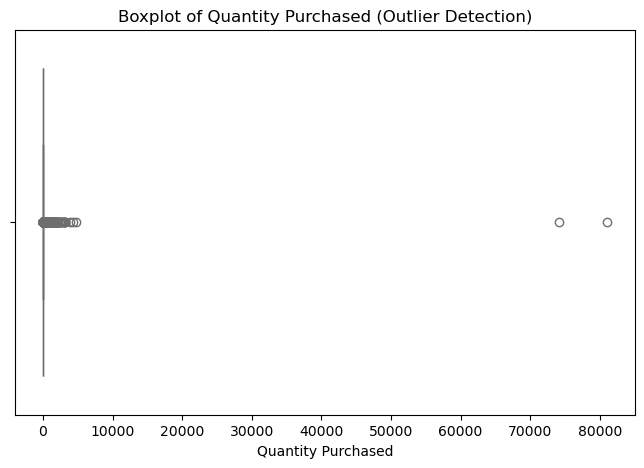

In [698]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_cleaned["Quantity"], color="lightcoral")
plt.xlabel("Quantity Purchased")
plt.title("Boxplot of Quantity Purchased (Outlier Detection)")
plt.show()

In [714]:
# Calculate IQR
Q1 = df_cleaned[["Quantity"]].quantile(0.25)
print(f"Q1:{Q1}")
Q3 = df_cleaned[["Quantity"]].quantile(0.75)
print(f"Q3:{Q3}")
IQR = Q3 - Q1
print(f"IQR:{IQR}")

lower_bound = Q1 - (1.5 * IQR) 
upper_bound = Q3 + (1.5 * IQR) 

print(f"lower_bound: {lower_bound}")
print(f"upper_bound: {upper_bound}")

# Define outliers (1.5*IQR rule)
outliers_top = ((df_cleaned[["Quantity"]] > (upper_bound)))

print(outliers_top.sum())

Q1:Quantity    1.0
Name: 0.25, dtype: float64
Q3:Quantity    6.0
Name: 0.75, dtype: float64
IQR:Quantity    5.0
dtype: float64
lower_bound: Quantity   -6.5
dtype: float64
upper_bound: Quantity    13.5
dtype: float64
Quantity    13213
dtype: int64


In [722]:
upper_bound_value = upper_bound.iloc[0]  # Extract scalar value
df_cleaned = df_cleaned[df_cleaned["Quantity"] < int(upper_bound_value)]

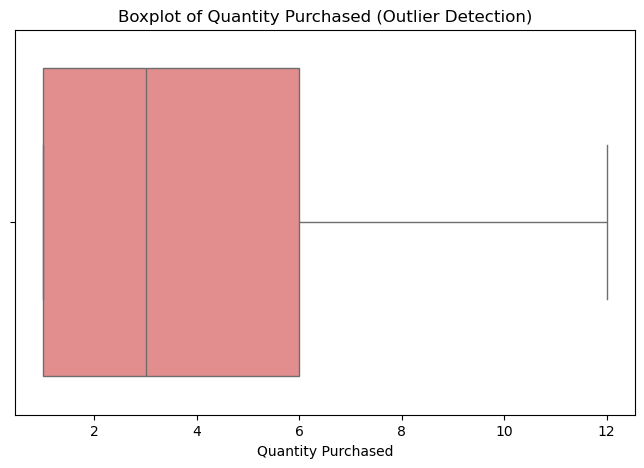

In [724]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_cleaned["Quantity"], color="lightcoral")
plt.xlabel("Quantity Purchased")
plt.title("Boxplot of Quantity Purchased (Outlier Detection)")
plt.show()

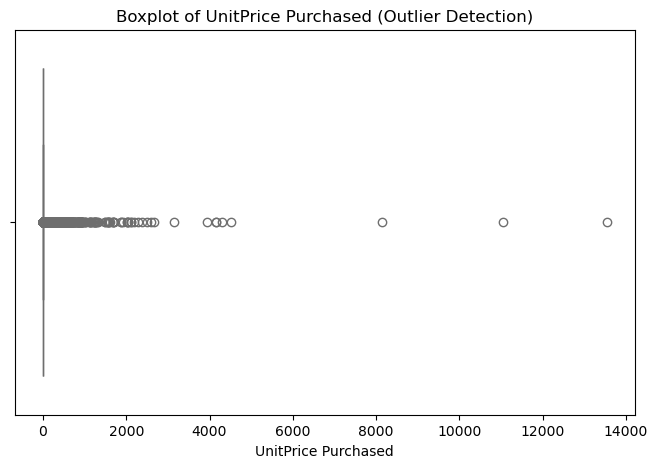

In [728]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_cleaned["UnitPrice"], color="lightcoral")
plt.xlabel("UnitPrice Purchased")
plt.title("Boxplot of UnitPrice Purchased (Outlier Detection)")
plt.show()

In [730]:
temp = df_cleaned[df_cleaned["UnitPrice"] > 6000]
print(temp.shape)

(3, 10)


In [744]:
temp = df_cleaned[df_cleaned["UnitPrice"] > 6000]
temp.head(10)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
15017,15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,0,United Kingdom,13541.33
173382,173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom,8142.75
299982,299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,0,United Kingdom,11062.06


In [746]:
df_cleaned = df_cleaned[df_cleaned["UnitPrice"] < 6000]

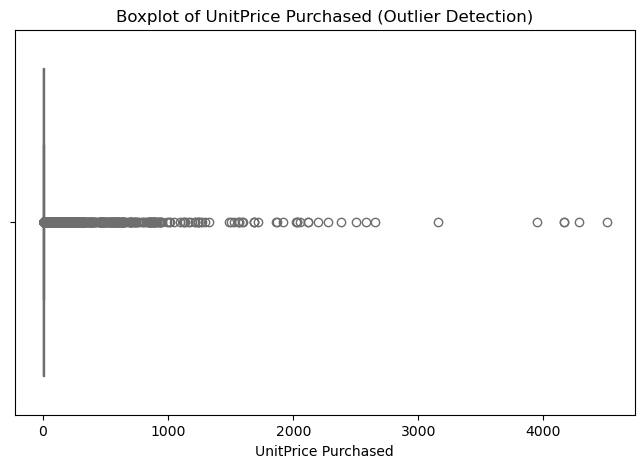

In [748]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_cleaned["UnitPrice"], color="lightcoral")
plt.xlabel("UnitPrice Purchased")
plt.title("Boxplot of UnitPrice Purchased (Outlier Detection)")
plt.show()

In [594]:
#df_cleaned = df_cleaned[df_cleaned["UnitPrice"] < 2500]

In [596]:
#temp = df_cleaned[df_cleaned["Quantity"] > 2500]
#print(temp.shape)

(11, 10)


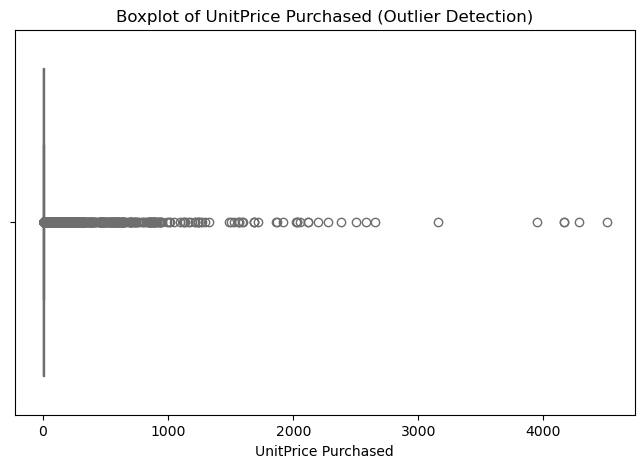

In [750]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_cleaned["UnitPrice"], color="lightcoral")
plt.xlabel("UnitPrice Purchased")
plt.title("Boxplot of UnitPrice Purchased (Outlier Detection)")
plt.show()

In [738]:
#df_cleaned = df_cleaned[df_cleaned["Quantity"] < 2500]

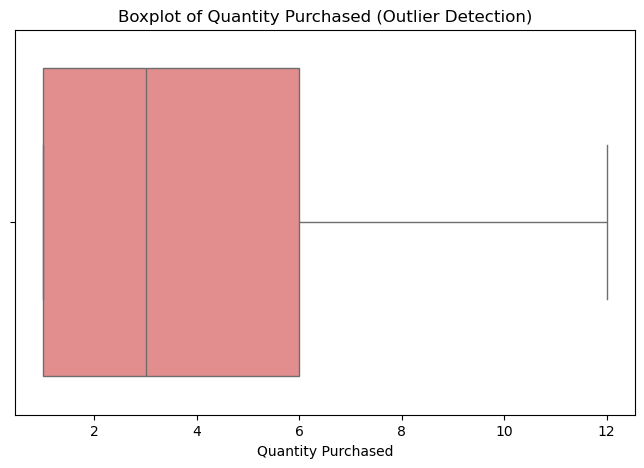

In [752]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_cleaned["Quantity"], color="lightcoral")
plt.xlabel("Quantity Purchased")
plt.title("Boxplot of Quantity Purchased (Outlier Detection)")
plt.show()

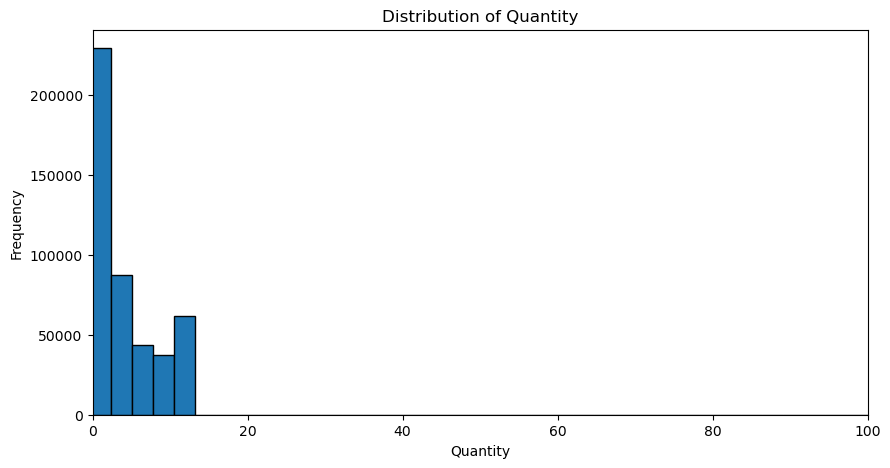

In [754]:
# Visualize distributions of numerical features using histograms
bin_edges = np.linspace(-60, 100, 60)

# Plot histogram for 'quantity'
plt.figure(figsize=(10, 5))
plt.hist(df_cleaned['Quantity'], bins=bin_edges, edgecolor='black')
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.xlim(0,100)
plt.show()


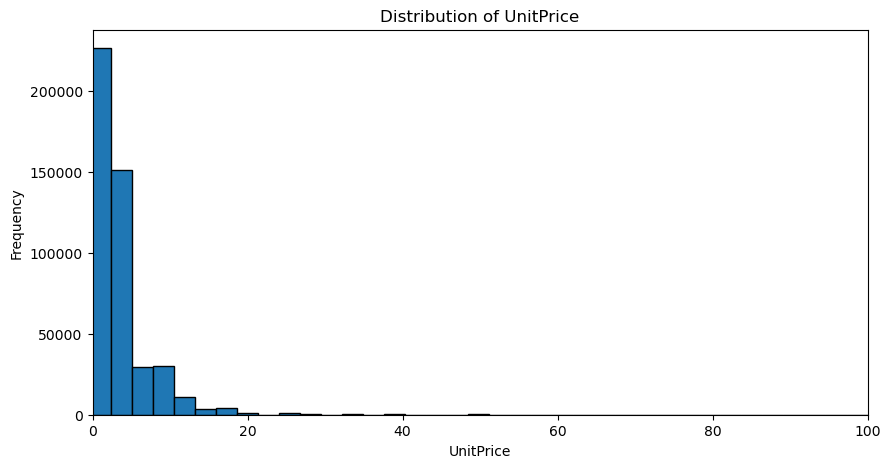

In [756]:
# Visualize distributions of numerical features using histograms
bin_edges = np.linspace(-60, 100, 60)

# Plot histogram for 'quantity'
plt.figure(figsize=(10, 5))
plt.hist(df_cleaned['UnitPrice'], bins=bin_edges, edgecolor='black')
plt.title('Distribution of UnitPrice')
plt.xlabel('UnitPrice')
plt.ylabel('Frequency')
plt.xlim(0,100)
plt.show()


#### Visualizing Correlation Between Numerical Features

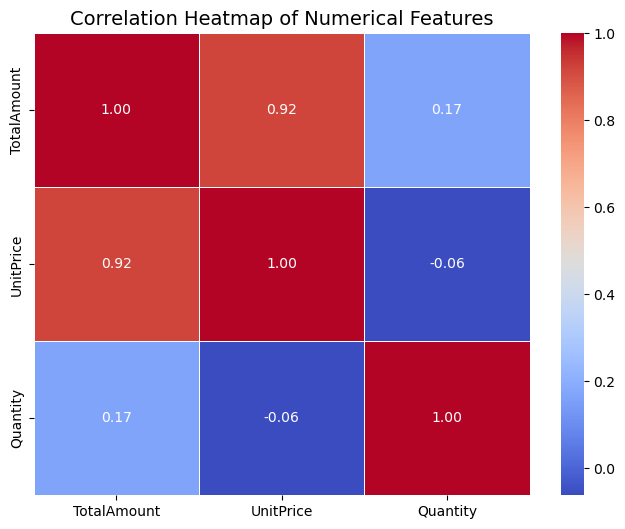

In [758]:
# Compute correlation matrix
correlation_matrix = df_cleaned[["TotalAmount", "UnitPrice", "Quantity"]].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")

# Set title
plt.title("Correlation Heatmap of Numerical Features", fontsize=14)

# Show plot
plt.show()

In [760]:
temp = df_cleaned[(df_cleaned['CustomerID'] > 0)]

In [762]:

# Aggregate total quantity purchased by each CustomerID
customer_orders = temp.groupby("CustomerID")["Quantity"].sum().reset_index()

# Rename columns for clarity
customer_orders.columns = ["CustomerID", "TotalQuantity"]

# Display top 10 customers with the highest total orders
print(customer_orders.sort_values(by="TotalQuantity", ascending=False).head(10))


      CustomerID  TotalQuantity
1824       14911          32672
3879       17841          16669
1252       14096          12609
545        13089          11551
323        12748          11107
2109       15311           5973
1907       15039           5800
541        13081           5318
1293       14156           5241
3813       17735           4728


In [778]:
# Compute IQR
Q1 = customer_orders["TotalQuantity"].quantile(0.25)
Q3 = customer_orders["TotalQuantity"].quantile(0.75)
IQR = Q3 - Q1

# Define threshold for anomalies
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"lower_bound of total quantity:{lower_bound}")
print(f"upper_bound of total quantity:{upper_bound}")

# Identify customers with unusually high order quantities
anomalous_customers = customer_orders[customer_orders["TotalQuantity"] > upper_bound]

# Display anomalous customers
print(f"Total Anomalous Customers: {len(anomalous_customers)}")
print(anomalous_customers)

lower_bound of total quantity:-493.25
upper_bound of total quantity:1040.75
Total Anomalous Customers: 373
      CustomerID  TotalQuantity
0          12347           1152
11         12359           1352
14         12362           1805
26         12378           1410
65         12428           1777
...          ...            ...
4145       18225           1663
4146       18226           1526
4161       18245           1306
4178       18272           1214
4186       18283           1384

[373 rows x 2 columns]


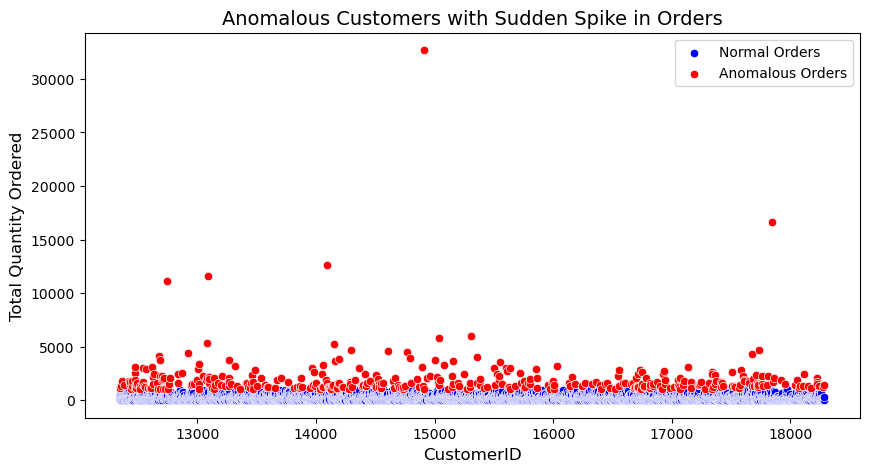

In [766]:
# Plot all customers
plt.figure(figsize=(10, 5))
sns.scatterplot(x=customer_orders["CustomerID"], y=customer_orders["TotalQuantity"], color="blue", label="Normal Orders")

# Highlight anomalies
sns.scatterplot(x=anomalous_customers["CustomerID"], y=anomalous_customers["TotalQuantity"], color="red", label="Anomalous Orders")

# Set labels
plt.xlabel("CustomerID", fontsize=12)
plt.ylabel("Total Quantity Ordered", fontsize=12)
plt.title("Anomalous Customers with Sudden Spike in Orders", fontsize=14)
plt.legend()

# Show plot
plt.show()


In [782]:
temp_customers = customer_orders[customer_orders["TotalQuantity"] > 6000]
temp_customers.head(20)

,CustomerID,TotalQuantity
323,12748,11107
545,13089,11551
1252,14096,12609
1824,14911,32672
3879,17841,16669


Removed 5 customers from the dataset.
lower_bound of total quantity:-491.0
upper_bound of total quantity:1037.0
Total Anomalous Customers: 372
      CustomerID  TotalQuantity
0          12347           1152
11         12359           1352
14         12362           1805
26         12378           1410
65         12428           1777
...          ...            ...
4140       18225           1663
4141       18226           1526
4156       18245           1306
4173       18272           1214
4181       18283           1384

[372 rows x 2 columns]


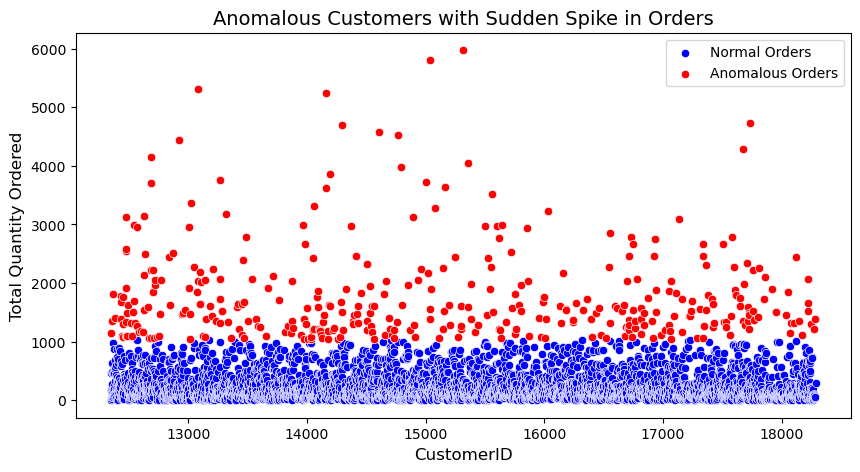

In [792]:
# Filter customers who ordered more than 5000 units
customers_to_remove = customer_orders[customer_orders["TotalQuantity"] > 6000]["CustomerID"]

# Remove those customers from the original dataset
df_temp = temp[~temp["CustomerID"].isin(customers_to_remove)]

# Print confirmation message
print(f"Removed {len(customers_to_remove)} customers from the dataset.")

# 🔄 **Recalculate `customer_orders` after removal**
customer_orders_updated = df_temp.groupby("CustomerID")["Quantity"].sum().reset_index()
customer_orders_updated.columns = ["CustomerID", "TotalQuantity"]

# Compute IQR
Q1 = customer_orders_updated["TotalQuantity"].quantile(0.25)
Q3 = customer_orders_updated["TotalQuantity"].quantile(0.75)
IQR = Q3 - Q1

# Define threshold for anomalies
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"lower_bound of total quantity:{lower_bound}")
print(f"upper_bound of total quantity:{upper_bound}")

# Identify customers with unusually high order quantities
anomalous_customers = customer_orders_updated[customer_orders_updated["TotalQuantity"] > upper_bound]

# Display anomalous customers
print(f"Total Anomalous Customers: {len(anomalous_customers)}")
print(anomalous_customers)

plt.figure(figsize=(10, 5))
sns.scatterplot(x=customer_orders_updated["CustomerID"], y=customer_orders_updated["TotalQuantity"], color="blue", label="Normal Orders")

# Highlight anomalies
sns.scatterplot(x=anomalous_customers["CustomerID"], y=anomalous_customers["TotalQuantity"], color="red", label="Anomalous Orders")

# Set labels
plt.xlabel("CustomerID", fontsize=12)
plt.ylabel("Total Quantity Ordered", fontsize=12)
plt.title("Anomalous Customers with Sudden Spike in Orders", fontsize=14)
plt.legend()

# Show plot
plt.show()


In [452]:
# Compute Z-scores for Quantity
df["z_score"] = stats.zscore(df["Quantity"])

# Find outliers (Threshold: |Z-score| > 3)
outliers = df[df["z_score"].abs() > 3]
print(f"Total Outliers: {len(outliers)}")
print(outliers.head(10))


Total Outliers: 346
       index InvoiceNo StockCode                          Description  \
4287    4287   C536757     84347  ROTATING SILVER ANGELS T-LIGHT HLDR   
4850    4850    536809     84950       ASSORTED COLOUR T-LIGHT HOLDER   
4945    4945    536830     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS   
4946    4946    536830     21915               RED  HARMONICA IN BOX    
6365    6365    536890    17084R                ASSORTED INCENSE PACK   
9745    9745    537214     17003                  BROCADE RING PURSE    
16427  16427    537657     22189              CREAM HEART CARD HOLDER   
16428  16428    537657     22188              BLACK HEART CARD HOLDER   
16435  16435    537659     22189              CREAM HEART CARD HOLDER   
16436  16436    537659     22188              BLACK HEART CARD HOLDER   

       Quantity         InvoiceDate  UnitPrice  CustomerID         Country  \
4287      -9360 2010-12-02 14:23:00       0.03       15838  United Kingdom   
4850       1824 2010

/var/folders/0p/29y5gpjs09jd6rt_9jltqj7w0000gn/T/ipykernel_52427/3709428961.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quantity', y='Description', data=top_10_products, palette='viridis')


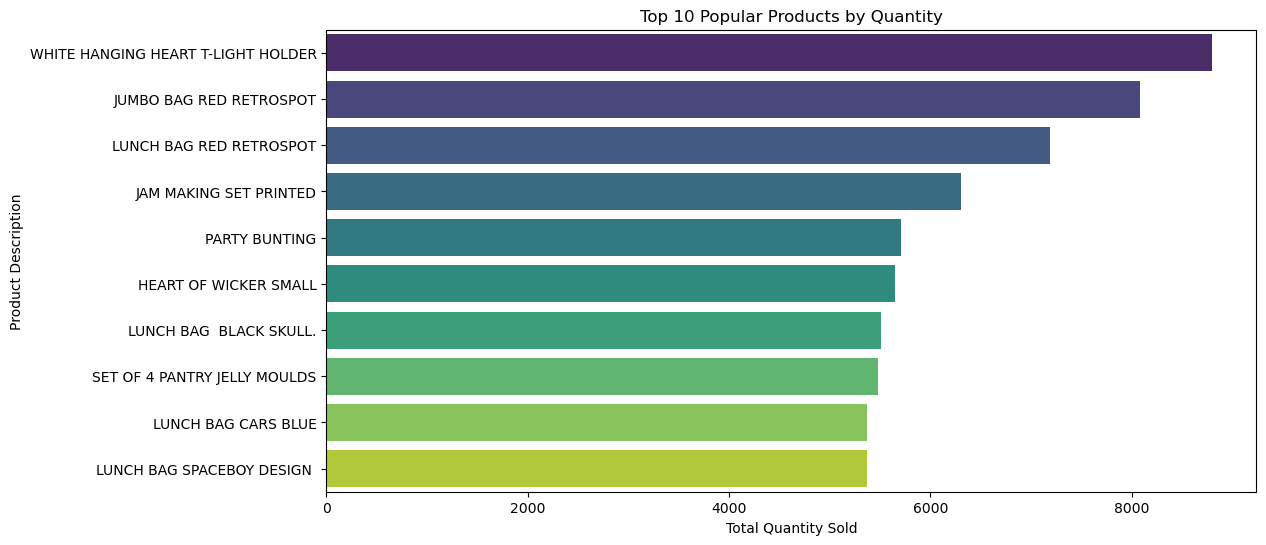

In [794]:
# Aggregate total quantity sold per product
popular_products = df_temp.groupby('Description')['Quantity'].sum().reset_index()

# Sort by highest quantity and take the top 10
top_10_products = popular_products.sort_values(by='Quantity', ascending=False).head(10)

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Quantity', y='Description', data=top_10_products, palette='viridis')

# Add labels and title
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Description')
plt.title('Top 10 Popular Products by Quantity')
plt.show()

In [798]:
temp = df_cleaned[df_cleaned['InvoiceNo'].astype(str).str.startswith('C')]  
temp.head(20)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount


In [800]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'C2', 'DOT', 'M', 'BANK CHARGES', 'DCGS0076', 'DCGS0003',
       'gift_0001_40', 'DCGS0070', 'm', 'gift_0001_50', 'gift_0001_30',
       'gift_0001_20', 'DCGS0069', 'DCGSSBOY', 'DCGSSGIRL',
       'gift_0001_10', 'AMAZONFEE', 'S', 'PADS', 'DCGS0004'], dtype=object)

In [806]:
list_special_codes.size

21

In [820]:
# Extract special codes that contain only letters
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()

# Filter dataset to include only rows with special StockCodes
df_special_codes = df_cleaned[df_cleaned['StockCode'].isin(list_special_codes)]

# Display the filtered data
df_special_codes.head(20)
#df_special_codes.size

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
45,45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583,France,54.00
386,386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791,Netherlands,15.00
1123,1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662,Germany,18.00
1423,1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.00,14911,EIRE,50.00
1814,1814,536544,DOT,DOTCOM POSTAGE,1,2010-12-01 14:32:00,569.77,0,United Kingdom,569.77
2239,2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274,United Kingdom,1.25
2250,2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274,United Kingdom,18.95
3041,3041,536592,DOT,DOTCOM POSTAGE,1,2010-12-01 17:06:00,607.49,0,United Kingdom,607.49
4406,4406,536779,BANK CHARGES,Bank Charges,1,2010-12-02 15:08:00,15.00,15823,United Kingdom,15.00
5073,5073,536840,POST,POSTAGE,1,2010-12-02 18:27:00,18.00,12738,Germany,18.00


In [824]:
# Extract unique StockCode and Description pairs for list_special_codes
unique_stock_descriptions = df_cleaned[df_cleaned['StockCode'].isin(list_special_codes)][['StockCode', 'Description']].drop_duplicates()

# Display the unique StockCode and Description pairs
for index, row in unique_stock_descriptions.iterrows():
    print(f"StockCode: {row['StockCode']} - Description: {row['Description']}")


StockCode: POST - Description: POSTAGE
StockCode: C2 - Description: CARRIAGE
StockCode: DOT - Description: DOTCOM POSTAGE
StockCode: M - Description: Manual
StockCode: BANK CHARGES - Description: Bank Charges
StockCode: DCGS0076 - Description: SUNJAR LED NIGHT NIGHT LIGHT
StockCode: DCGS0003 - Description: BOXED GLASS ASHTRAY
StockCode: gift_0001_40 - Description: Dotcomgiftshop Gift Voucher £40.00
StockCode: DCGS0070 - Description: CAMOUFLAGE DOG COLLAR
StockCode: m - Description: Manual
StockCode: gift_0001_50 - Description: Dotcomgiftshop Gift Voucher £50.00
StockCode: gift_0001_30 - Description: Dotcomgiftshop Gift Voucher £30.00
StockCode: gift_0001_20 - Description: Dotcomgiftshop Gift Voucher £20.00
StockCode: DCGS0069 - Description: OOH LA LA DOGS COLLAR
StockCode: DCGSSBOY - Description: BOYS PARTY BAG
StockCode: DCGSSGIRL - Description: GIRLS PARTY BAG
StockCode: gift_0001_10 - Description: Dotcomgiftshop Gift Voucher £10.00
StockCode: AMAZONFEE - Description: AMAZON FEE
Stoc

In [ ]:
array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)